In [2]:
import numpy as np
import pandas as pd
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import math

In [3]:
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [5]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_data = pd.read_csv("/content/drive/My Drive/Ocular Dataset/Dataset/full_df.csv")
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [7]:
df_data[df_data.C==1].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
65,81,66,Male,81_left.jpg,81_right.jpg,moderate non proliferative retinopathy，cataract,moderate non proliferative retinopathy，cataract,0,1,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",81_right.jpg
86,103,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg


In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [9]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

In [10]:
df_data2 = df_data.iloc[:, 1:7]
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [11]:
img_dir = "/content/drive/My Drive/Ocular Dataset/Dataset/preprocessed_images"

In [12]:
df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
86,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus
100,59,Male,119_left.jpg,119_right.jpg,cataract,drusen
218,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane
256,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus


In [13]:
df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df_left_cat))

294


In [14]:
df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [15]:
df_rt_cat = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df_rt_cat))

278


In [16]:
df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


In [17]:
df_data[df_data['Left-Diagnostic Keywords'].str.match('cataract')].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
86,103,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg
100,119,59,Male,119_left.jpg,119_right.jpg,cataract,drusen,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",119_right.jpg
218,254,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",254_right.jpg
256,294,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",294_right.jpg


In [18]:
df_data[df_data['Right-Diagnostic Keywords'].str.match('cataract')].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg
160,188,55,Female,188_left.jpg,188_right.jpg,laser spot，severe proliferative diabetic retin...,cataract,0,1,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",188_right.jpg
186,218,36,Female,218_left.jpg,218_right.jpg,refractive media opacity,cataract,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",218_right.jpg
309,354,65,Male,354_left.jpg,354_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",354_right.jpg


In [19]:
df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)
df_cat_filenames.head()

<ipython-input-19-e401f10684d0>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)


0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

In [20]:
len(df_cat_filenames)

572

In [21]:
df_cat_filenames.head()

0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

In [22]:
df_cat_filenames.tail()

567    2243_right.jpg
568    2246_right.jpg
569    2247_right.jpg
570    2248_right.jpg
571    2282_right.jpg
dtype: object

(512, 512, 3)
1126_right.jpg


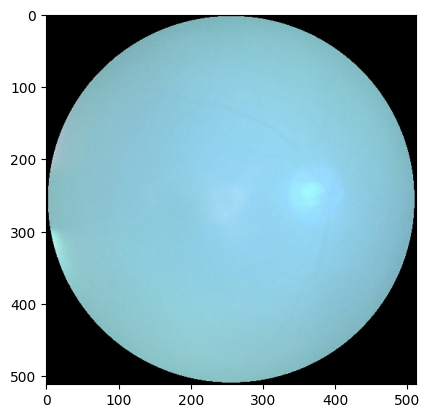

In [23]:
img = df_cat_filenames[312]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

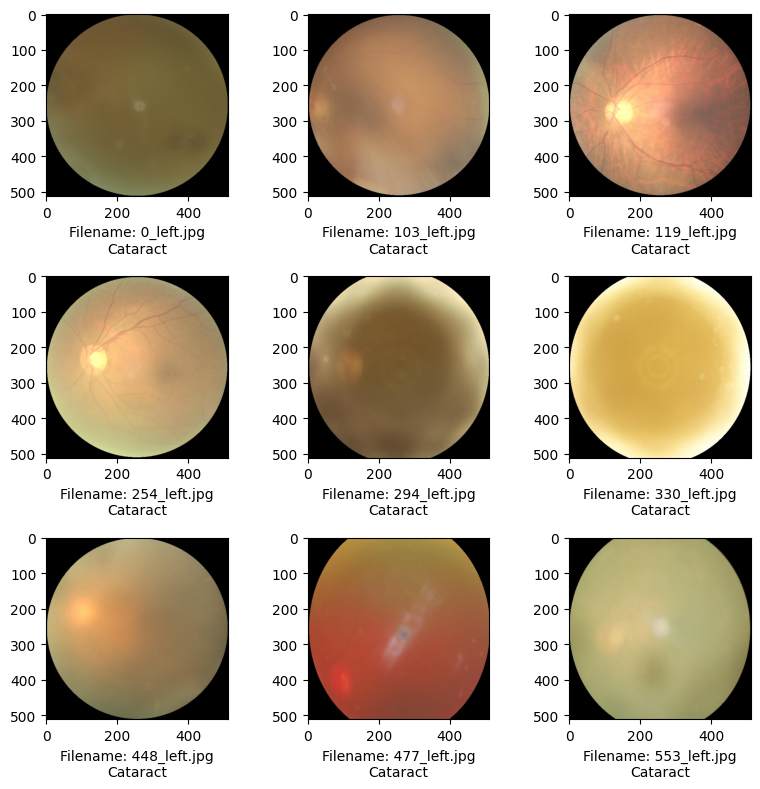

In [24]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_cat_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    plt.xlabel('Filename: {}\n''Cataract'.format(df_cat_filenames[i]))
plt.tight_layout() 

In [25]:
df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)
df_norm_filenames

<ipython-input-25-949d248025f1>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)


0           1_left.jpg
1           8_left.jpg
2           9_left.jpg
3          14_left.jpg
4          15_left.jpg
             ...      
5585    4642_right.jpg
5586    4644_right.jpg
5587    4660_right.jpg
5588    4671_right.jpg
5589    4689_right.jpg
Length: 5590, dtype: object

In [26]:
df_norm_filenames_random = df_norm_filenames.sample(n = 572)
df_norm_filenames_random.head()

951      3101_left.jpg
477      2566_left.jpg
3282    2482_right.jpg
4284     144_right.jpg
4007    3268_right.jpg
dtype: object

In [27]:
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0       3101_left.jpg
1       2566_left.jpg
2      2482_right.jpg
3       144_right.jpg
4      3268_right.jpg
            ...      
567    2789_right.jpg
568    3329_right.jpg
569     2917_left.jpg
570     2402_left.jpg
571     2433_left.jpg
Length: 572, dtype: object

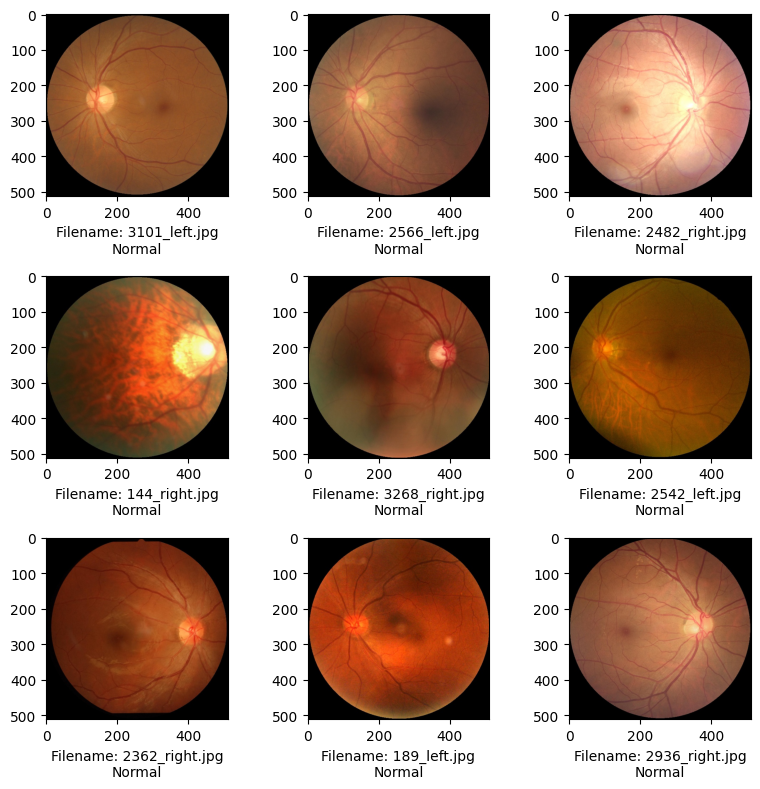

In [28]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))
plt.tight_layout() 

In [29]:
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])
df_cat_filenames.head()

,filename
0,0_left.jpg
1,103_left.jpg
2,119_left.jpg
3,254_left.jpg
4,294_left.jpg


In [30]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
df_norm_filenames_random.head()

,filename
0,3101_left.jpg
1,2566_left.jpg
2,2482_right.jpg
3,144_right.jpg
4,3268_right.jpg


In [31]:
df_combined = df_cat_filenames.append(df_norm_filenames_random, ignore_index=True)
df_combined

<ipython-input-31-d381ac5e70cc>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_cat_filenames.append(df_norm_filenames_random, ignore_index=True)


,filename
0,0_left.jpg
1,103_left.jpg
2,119_left.jpg
3,254_left.jpg
4,294_left.jpg
...,...
1139,2789_right.jpg
1140,3329_right.jpg
1141,2917_left.jpg
1142,2402_left.jpg


In [32]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename
0,2678_right.jpg
1,2211_right.jpg
2,2233_right.jpg
3,354_right.jpg
4,2232_right.jpg
...,...
1139,2201_right.jpg
1140,2190_right.jpg
1141,2653_left.jpg
1142,2986_left.jpg


In [33]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [34]:
df_data["left_cataract"] = df_data["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df_data["right_cataract"] = df_data["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

left_cataract = df_data.loc[(df_data.C==1) & (df_data.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df_data.loc[(df_data.C==1) & (df_data.right_cataract == 1)]["Right-Fundus"].values

In [35]:
left_normal = df_data.loc[(df_data.C ==0) & (df_data["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(2000,random_state=42).values
right_normal = df_data.loc[(df_data.C ==0) & (df_data["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(2000,random_state=42).values
right_normal[:15]

cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [36]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dim=224
img_dir = "/content/drive/My Drive/Ocular Dataset/Dataset/preprocessed_images/"
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(img_dir,img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (dim, dim))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        except:
            continue
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [38]:
dataset = create_dataset(cataract,1)
len(dataset)
dataset = create_dataset(normal,0)
len(dataset)

100%|██████████| 4000/4000 [28:32<00:00,  2.34it/s]


4588

In [39]:
from sklearn.model_selection import train_test_split
X = [datapoint[0] for datapoint in dataset] # Extract the images from the dataset
Y = [datapoint[1] for datapoint in dataset] # Extract the labels from the dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [40]:
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0

In [41]:
model = Sequential()

In [42]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
image_size = 224
X = []  # list to hold the images
Y = []  # list to hold the labels
for image, label in dataset:
    image = cv2.resize(image, (image_size, image_size))
    X.append(image)
    Y.append(label)
X = np.array(X)
Y = np.array(Y)

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)     

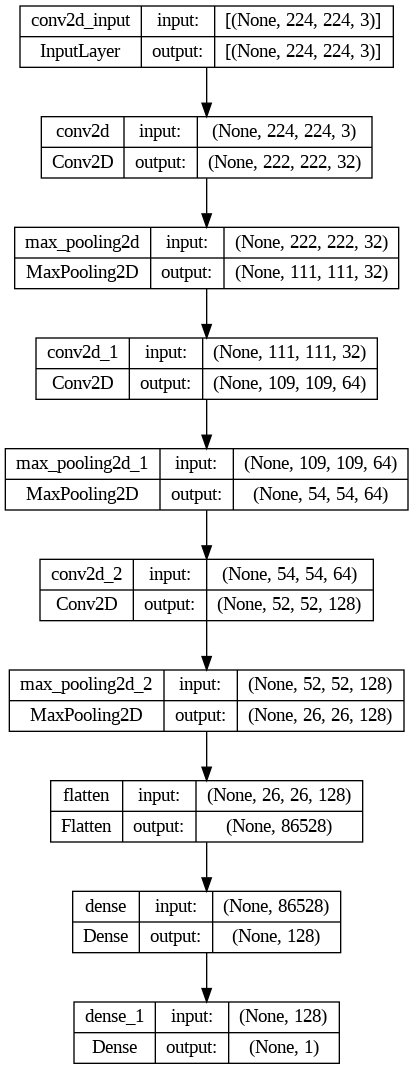

In [46]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [47]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [48]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
115/115 [==============================] - 19s 52ms/step - loss: 17.9583 - accuracy: 0.8469 - val_loss: 0.4153 - val_accuracy: 0.8671
Epoch 2/10
115/115 [==============================] - 5s 47ms/step - loss: 0.3510 - accuracy: 0.8793 - val_loss: 0.3913 - val_accuracy: 0.8649
Epoch 3/10
115/115 [==============================] - 5s 46ms/step - loss: 0.3257 - accuracy: 0.8812 - val_loss: 0.3652 - val_accuracy: 0.8715
Epoch 4/10
115/115 [==============================] - 5s 46ms/step - loss: 0.2995 - accuracy: 0.8880 - val_loss: 0.3669 - val_accuracy: 0.8627
Epoch 5/10
115/115 [==============================] - 6s 49ms/step - loss: 0.2889 - accuracy: 0.8918 - val_loss: 0.3678 - val_accuracy: 0.8704
Epoch 6/10
115/115 [==============================] - 5s 44ms/step - loss: 0.2711 - accuracy: 0.8954 - val_loss: 0.3364 - val_accuracy: 0.8704
Epoch 7/10
115/115 [==============================] - 6s 48ms/step - loss: 0.2573 - accuracy: 0.8995 - val_loss: 0.3366 - val_accuracy: 0.87

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
history = model.fit(X_train, Y_train, batch_size=32, epochs=10,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping, lr_reducer])

Epoch 1/10
115/115 [==============================] - 6s 50ms/step - loss: 0.2180 - accuracy: 0.9139 - val_loss: 0.3309 - val_accuracy: 0.8834 - lr: 0.0010
Epoch 2/10
115/115 [==============================] - 5s 46ms/step - loss: 0.2237 - accuracy: 0.9128 - val_loss: 0.3110 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 3/10
115/115 [==============================] - 5s 47ms/step - loss: 0.1882 - accuracy: 0.9278 - val_loss: 0.2974 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 4/10
115/115 [==============================] - 5s 45ms/step - loss: 0.1905 - accuracy: 0.9245 - val_loss: 0.2874 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 5/10
115/115 [==============================] - 5s 47ms/step - loss: 0.1572 - accuracy: 0.9433 - val_loss: 0.3474 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 6/10
115/115 [==============================] - 5s 48ms/step - loss: 0.1352 - accuracy: 0.9507 - val_loss: 0.2824 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 7/10
115/115 [==============================] - 5s 47ms/st

In [50]:
loss,accuracy = model.evaluate(X_test,Y_test)

29/29 [==============================] - 0s 15ms/step - loss: 0.2609 - accuracy: 0.9423


In [51]:
print("loss:",loss)
print("Accuracy:",accuracy)

loss: 0.2608935534954071
Accuracy: 0.9422658085823059


In [52]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred > 0.5).astype(int)

29/29 [==============================] - 0s 14ms/step


In [53]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       792
           1       0.88      0.67      0.76       126

    accuracy                           0.94       918
   macro avg       0.91      0.83      0.86       918
weighted avg       0.94      0.94      0.94       918



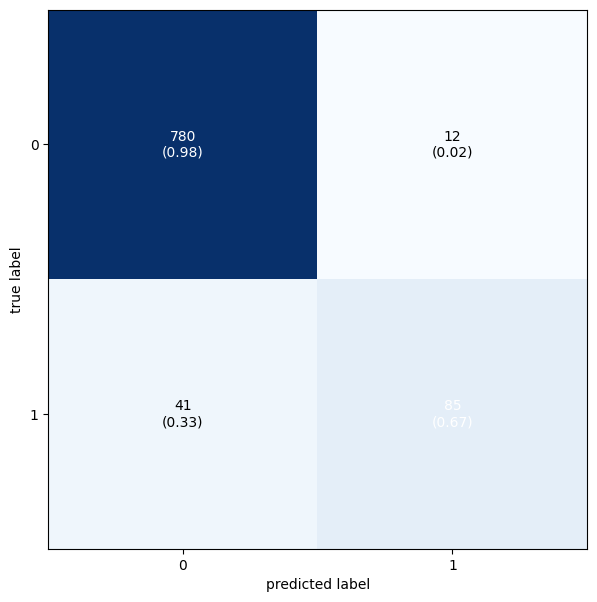

In [54]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(Y_test,Y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),
                      show_normed = True);

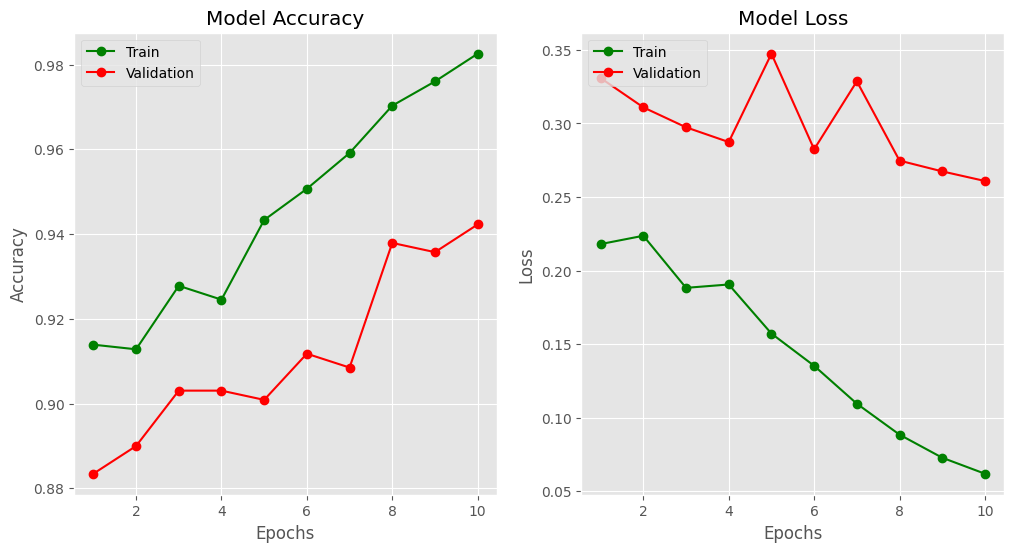

In [55]:
import matplotlib.pyplot as plt

# Use the "ggplot" style for the plots
plt.style.use("ggplot")

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Get the training and validation accuracy and loss
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
ax[0].plot(epochs, acc, "go-", label="Train")
ax[0].plot(epochs, val_acc, "ro-", label="Validation")
ax[0].set_title("Model Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="upper left")

# Plot the training and validation loss
ax[1].plot(epochs, loss, "go-", label="Train")
ax[1].plot(epochs, val_loss, "ro-", label="Validation")
ax[1].set_title("Model Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper left")

# Show the plots
plt.show()


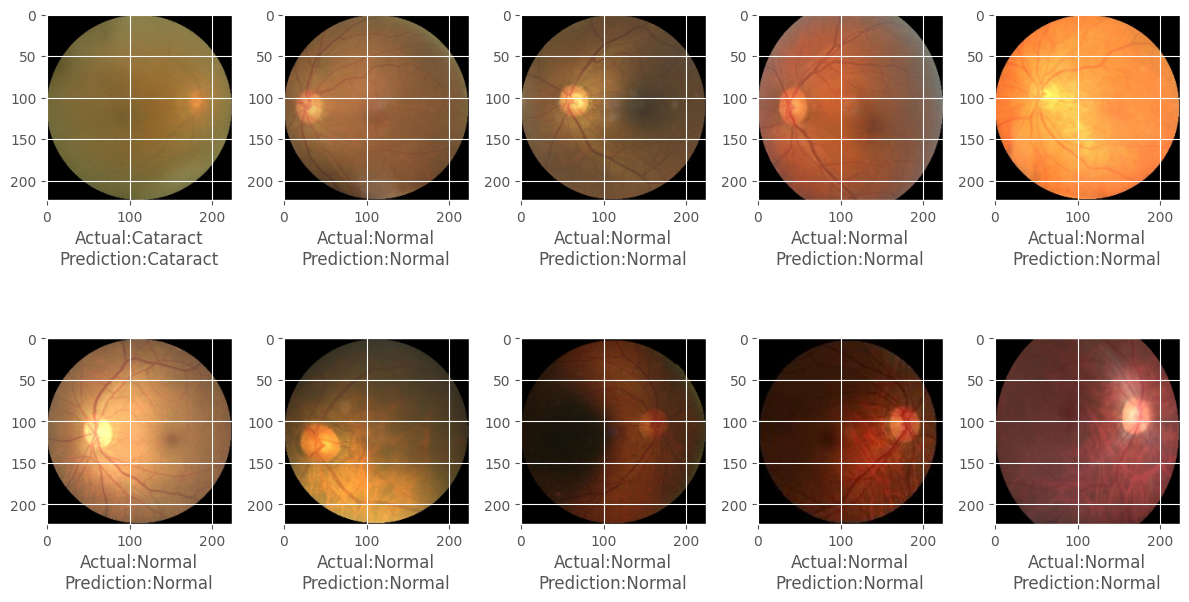

In [58]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(X_test)))
    image = X_test[sample]
    category = Y_test[sample]
    pred_category = Y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 
